## Exploring data quality

### Main findings

1. Original data - 225384 samples

2. Among all 250 drugs, 15 drugs have 2 different drug_id:
<br> 'AKT inhibitor VIII': [228, 171], 'AZD6482': [156, 1066], 'Afatinib': [1032, 1377], 'Avagacestat': [205, 1072], 'BMS-536924': [62, 1091], 'Bicalutamide': [150, 1502], 'CHIR-99021': [154, 1241], 'GSK269962A': [127, 1192], 'JQ1': [163, 1218], 'Olaparib': [1017, 1495], 'PLX-4720': [1036, 1371], 'Pictilisib': [1058, 1527], 'Refametinib': [1014, 1526], 'Selumetinib': [1062, 1498], 'UNC0638': [245, 1236]
3. For all the pairs drug+CCL with one concentraion and two records, one of the records is reduced, i.e has missing values
4. There are 33740 profiles with missing points. And among them only 9120 have dublicates/alternatives
5. Curves with up to 7 suspiciously high normalised responses can look pretty reasonable


# Main question - what drug response curves are valid for further analysis

In [1]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(1, os.path.relpath("../functions"))
from filtering import *
from plotting import *

_FOLDER = "../data/"
_FOLDER_2 = "../figures/"
_FOLDER_3 = "../results/"
SAVE_FIGURES = False

### Original data

In [2]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")

if "Unnamed: 0" in drug_curves:
    drug_curves.drop("Unnamed: 0", axis=1, inplace =True)

col_to_drop = ["per_slope_change_"+str(i) for i in range(8)]+\
            ["slope_" + str(i) for i in range(9)]    
drug_curves.drop(col_to_drop, axis=1, inplace=True)    
    
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]
CCL_names = dict(zip(drug_curves["COSMIC_ID"], drug_curves["CELL_LINE_NAME"]))
df= pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_names = dict(zip(df["Drug ID"].values, df["Drug Name"].values))
del df
drug_curves["drug_name"] = drug_curves["DRUG_ID"].map(drug_names)
drug_curves["CCL_name"] = drug_curves["COSMIC_ID"].map(CCL_names)
drug_curves.shape

(225384, 28)

In [3]:
drug_curves["MAX_CONC"].value_counts()

20.0000      29693
10.2400      29275
10.0000      28841
2.0000       15984
5.1200       15672
5.0000       15154
16.0000      11652
2.5600        8985
4.0000        8315
1.0240        8032
1.0000        5838
8.0000        5415
0.1000        4150
32.0000       3771
0.1280        2903
0.5120        2814
0.5000        2733
0.2000        2681
2.5000        2295
0.2560        2212
4000.0000     1916
1.2800        1791
0.2500        1712
5.2400         980
40.0000        975
50.0000        973
0.0500         969
6.6000         967
30.0000        945
0.0640         941
0.0080         932
64.0000        932
0.0320         932
65.8000        911
0.0125         894
2000.0000      893
1.2000         427
0.0200         427
0.1024         427
6.0000          25
Name: MAX_CONC, dtype: int64

In [4]:
drug_curves["FOLD_DILUTION"].value_counts()

2    191644
4     33740
Name: FOLD_DILUTION, dtype: int64

# Part 1: Duplicates

### Some drugs have several Drug_Id

In [5]:
print("All drugs:", drug_curves["DRUG_ID"].nunique())
print("Unique drug names:", drug_curves["drug_name"].nunique())
gr = drug_curves.groupby("drug_name").agg(n_ids = ("DRUG_ID", "nunique"))
gr["n_ids"].value_counts()

All drugs: 265
Unique drug names: 250


1    235
2     15
Name: n_ids, dtype: int64

In [6]:
print("Drugs with several drug ids:")
multiple_ids = list(gr[gr["n_ids"]>1].index)
drugs_with_id = {}
for drug_name in multiple_ids:
    ids = drug_curves[drug_curves["drug_name"]== drug_name]["DRUG_ID"].unique()
    drugs_with_id[drug_name] = list(ids)
print(drugs_with_id)

Drugs with several drug ids:
{'AKT inhibitor VIII': [228, 171], 'AZD6482': [156, 1066], 'Afatinib': [1032, 1377], 'Avagacestat': [205, 1072], 'BMS-536924': [62, 1091], 'Bicalutamide': [150, 1502], 'CHIR-99021': [154, 1241], 'GSK269962A': [127, 1192], 'JQ1': [163, 1218], 'Olaparib': [1017, 1495], 'PLX-4720': [1036, 1371], 'Pictilisib': [1058, 1527], 'Refametinib': [1014, 1526], 'Selumetinib': [1062, 1498], 'UNC0638': [245, 1236]}


### Several MAX_CONC for a pair drug+CCL

In [7]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
conc_gr = drug_curves.groupby(["drug_name", "CCL_name"]).agg(n_conc = ("MAX_CONC", "nunique"),
                                                            n_samples = ("MAX_CONC", "count"),
                                                            sum_missing = ("count_missing", "sum"))
conc_gr.shape

(213603, 3)

In [8]:
df_multi = conc_gr[(conc_gr["n_conc"]>1) | (conc_gr["n_samples"]>1)].copy()
df_multi["compare"] = df_multi["n_conc"] - df_multi["n_samples"]
df_multi["compare"].value_counts()

 0    8573
-1    3208
Name: compare, dtype: int64

In [9]:
df_multi[df_multi["compare"] == 0]["n_conc"].value_counts()

2    8573
Name: n_conc, dtype: int64

In [10]:
df_multi["n_conc"].value_counts()

2    8573
1    3208
Name: n_conc, dtype: int64

In [11]:
conc_multi = df_multi[df_multi["n_conc"]>1]
conc_multi

n_conc  n_samples  sum_missing  compare
drug_name          CCL_name                                         
AKT inhibitor VIII 201T           2          2            0        0
                   22RV1          2          2            0        0
                   23132-87       2          2            0        0
                   42-MG-BA       2          2            0        0
                   451Lu          2          2            0        0
...                             ...        ...          ...      ...
UNC0638            YKG-1          2          2            4        0
                   YT             2          2            4        0
                   huH-1          2          2            4        0
                   no-10          2          2            4        0
                   no-11          2          2            4        0

[8573 rows x 4 columns]

In [12]:
conc_multi["sum_missing"].value_counts()

4    5912
0    2661
Name: sum_missing, dtype: int64

In [13]:
conc_multi[conc_multi["sum_missing"]==0]

n_conc  n_samples  sum_missing  compare
drug_name          CCL_name                                         
AKT inhibitor VIII 201T           2          2            0        0
                   22RV1          2          2            0        0
                   23132-87       2          2            0        0
                   42-MG-BA       2          2            0        0
                   451Lu          2          2            0        0
...                             ...        ...          ...      ...
Avagacestat        YKG-1          2          2            0        0
                   YT             2          2            0        0
                   huH-1          2          2            0        0
                   no-10          2          2            0        0
                   no-11          2          2            0        0

[2661 rows x 4 columns]

In [14]:
multi_pairs = df_multi[(df_multi["compare"]==0)
                       & (df_multi["n_conc"]==2)
                      & (df_multi["sum_missing"]==0)].index.unique()
len(multi_pairs)

2661

In [15]:
multi_pairs[1000]

('AZD6482', 'CAL-54')

In [16]:
drug_curves[(drug_curves["drug_name"]=="AKT inhibitor VIII") & (drug_curves["CCL_name"]=="201T")]

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
120529,201T,1287381,228,228_1287381,2,10.24,0,0.111111,0.222222,0.333333,...,0.904019,0.827873,0.777372,0.621030,0.444930,0.307593,0.286270,AKT inhibitor VIII,201T,0
126556,201T,1287381,171,171_1287381,2,2.56,0,0.111111,0.222222,0.333333,...,0.954209,0.743833,0.794453,0.789998,0.497759,0.641248,0.665556,AKT inhibitor VIII,201T,0


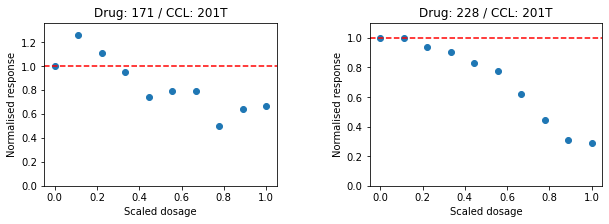

In [17]:
specific_samples = [(171, "201T"), #lower concentration
                    (228, "201T"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Conclusion: Low concentration didn't work well (but effect was recognisable), so they increased the concentration 4 times (case for drug_id=228) ???

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
109714,no-11,908450,205,205_908450,2,10.24,0,0.111111,0.222222,0.333333,...,0.945275,0.978555,0.958461,0.982709,0.958805,1.022682,0.988976,Avagacestat,no-11,0
161336,no-11,908450,1072,1072_908450,2,5.00,0,0.111111,0.222222,0.333333,...,0.674859,0.781196,0.928114,1.083455,0.847128,0.760488,0.847181,Avagacestat,no-11,0


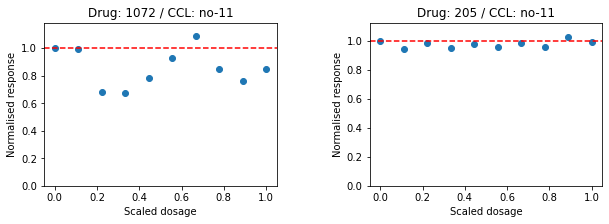

In [18]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="no-11")])

specific_samples = [(1072, "no-11"), #lower concentration
                    (205, "no-11"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Need for explanation: Some effect for low concentration and no effect for higher concentration???

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
122793,no-10,908452,205,205_908452,2,10.24,0,0.111111,0.222222,0.333333,...,0.988966,0.972152,0.976856,0.985122,0.973397,0.956278,1.046807,Avagacestat,no-10,0
167111,no-10,908452,1072,1072_908452,2,5.00,0,0.111111,0.222222,0.333333,...,0.953071,0.913611,0.964856,1.132595,0.893639,0.887503,0.885085,Avagacestat,no-10,0


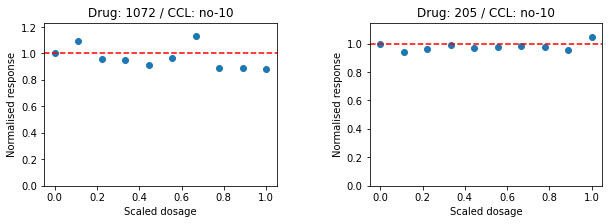

In [19]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="no-10")])

specific_samples = [(1072, "no-10"), #lower concentration
                    (205, "no-10"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
84299,YAPC,909904,205,205_909904,2,10.24,0,0.111111,0.222222,0.333333,...,0.991167,0.974232,0.962564,0.988538,0.993025,1.038742,1.009257,Avagacestat,YAPC,0
173538,YAPC,909904,1072,1072_909904,2,5.00,0,0.111111,0.222222,0.333333,...,0.916409,0.882748,0.865984,0.873287,0.978138,0.912739,0.885363,Avagacestat,YAPC,0


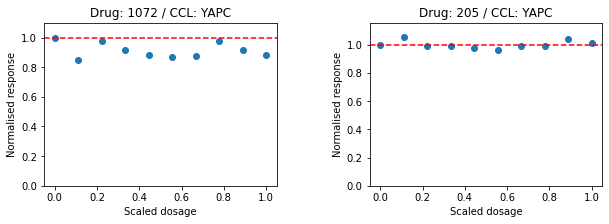

In [20]:
display(drug_curves[(drug_curves["drug_name"]=="Avagacestat") & (drug_curves["CCL_name"]=="YAPC")])

specific_samples = [(1072, "YAPC"), #lower concentration
                    (205, "YAPC"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1)

### Conclusion: Strange case for Avagacestat

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
30665,CAL-54,910952,156,156_910952,2,5.12,0,0.111111,0.222222,0.333333,...,0.790953,0.425658,0.968756,0.512320,0.831580,0.742309,0.343859,AZD6482,CAL-54,0
151706,CAL-54,910952,1066,1066_910952,2,5.00,0,0.111111,0.222222,0.333333,...,0.666333,0.746706,0.593387,0.510218,0.480783,0.438435,0.472617,AZD6482,CAL-54,0


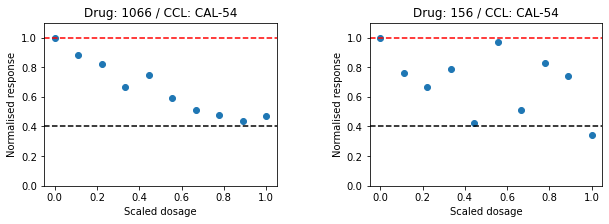

In [21]:
display(drug_curves[(drug_curves["drug_name"]=="AZD6482") & (drug_curves["CCL_name"]=="CAL-54")])

specific_samples = [(1066, "CAL-54"), #lower concentration
                    (156, "CAL-54"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1, lower_limit=0.4)

# Almost the same concentrations!!!

,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9,drug_name,CCL_name,count_missing
175276,22RV1,924100,1017,1017_924100,2,5.0,0,0.111111,0.222222,0.333333,...,1.175802,1.307469,1.236142,1.111566,1.129138,1.293295,0.949727,Olaparib,22RV1,0
210290,22RV1,924100,1495,1495_924100,4,10.0,0,0.200000,0.400000,0.600000,...,0.946075,1.015209,0.819707,NaN,NaN,NaN,NaN,Olaparib,22RV1,4


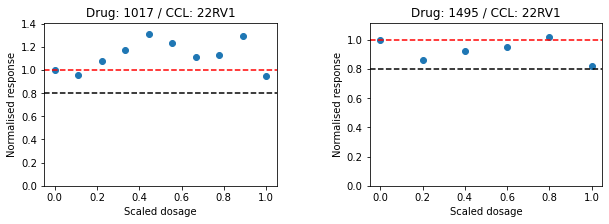

In [22]:
display(drug_curves[(drug_curves["drug_name"]=="Olaparib") & (drug_curves["CCL_name"]=="22RV1")])

specific_samples = [(1017, "22RV1"), #lower concentration
                    (1495, "22RV1"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, 
             drug_col ="DRUG_ID",  upper_limit =1, lower_limit=0.8)

## Pairs with one concentration and two records

In [23]:
df_multi[df_multi["compare"] == -1]["n_conc"].value_counts()

1    3208
Name: n_conc, dtype: int64

In [24]:
df_multi[(df_multi["compare"]==-1)]

n_conc  n_samples  sum_missing  compare
drug_name   CCL_name                                         
PLX-4720    22RV1          1          2            4       -1
            23132-87       1          2            4       -1
            42-MG-BA       1          2            4       -1
            451Lu          1          2            4       -1
            5637           1          2            4       -1
...                      ...        ...          ...      ...
Selumetinib YKG-1          1          2            4       -1
            YT             1          2            4       -1
            ZR-75-30       1          2            4       -1
            huH-1          1          2            4       -1
            no-11          1          2            4       -1

[3208 rows x 4 columns]

In [25]:
multi_pairs = list(df_multi[(df_multi["compare"]==-1)].index.unique())
len(multi_pairs)

3208

In [26]:
[multi_pairs[i] for i in [10, 1000, 2000, 3000]]

[('PLX-4720', '8305C'),
 ('Pictilisib', 'EN'),
 ('Refametinib', 'LS-411N'),
 ('Selumetinib', 'OVKATE')]

### One concentration and 2 records for each pair

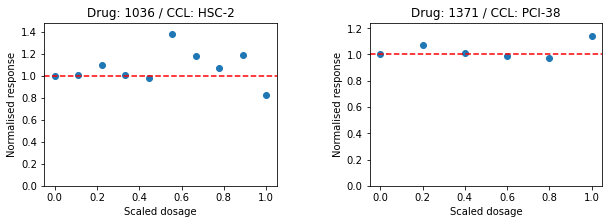

In [27]:
drug_curves[(drug_curves["drug_name"]=="PLX-4720")& (drug_curves["CCL_name"]=="22RV1")]

specific_samples = [(1036, "HSC-2"),
                    (1371, "PCI-38"),
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm, drug_col ="DRUG_ID",
            upper_limit =1)

### Hypothesis: for the pairs drug+CCL with one concentraion and two records, one of the records is reduced, i.e has missing values

In [28]:
nul_samples = df_multi[(df_multi["compare"]==-1) & (df_multi["sum_missing"]>0)].index.unique()

print("Total number of multiples:", len(multi_pairs))
print("Number of pairs with missing data:", len(nul_samples))

Total number of multiples: 3208
Number of pairs with missing data: 3208


### Conclusions: for all the pairs drug+CCL with one concentraion and two records, one of the records is reduced, i.e has missing values

# Part 2: Missing values

In [29]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
drug_curves["count_missing"].value_counts()

0    191644
4     33740
Name: count_missing, dtype: int64

In [30]:
df = drug_curves[drug_curves["count_missing"]!=0]
df[["drug_name", "CCL_name"] + conc_columns + response_norm].head()

,drug_name,CCL_name,fd_num_0,fd_num_1,fd_num_2,fd_num_3,fd_num_4,fd_num_5,fd_num_6,fd_num_7,...,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
191644,IOX2,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.010153,1.029382,1.114285,1.040530,1.115383,NaN,NaN,NaN,NaN
191645,UNC0638,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.075736,1.118267,1.005392,1.133969,1.086137,NaN,NaN,NaN,NaN
191646,UNC1215,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.016970,1.016753,1.000224,1.052226,1.004884,NaN,NaN,NaN,NaN
191647,Tamoxifen,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,1.057518,1.027474,0.978189,1.047974,0.962143,NaN,NaN,NaN,NaN
191648,(5Z)-7-Oxozeaenol,HDQ-P1,0,0.2,0.4,0.6,0.8,1.0,NaN,NaN,...,1,0.900644,0.945512,0.820547,0.208470,0.174570,NaN,NaN,NaN,NaN


## Conclusion: 33740 profiles have only 6 points (instead of usual 10)

Number of samples with missing data 33740


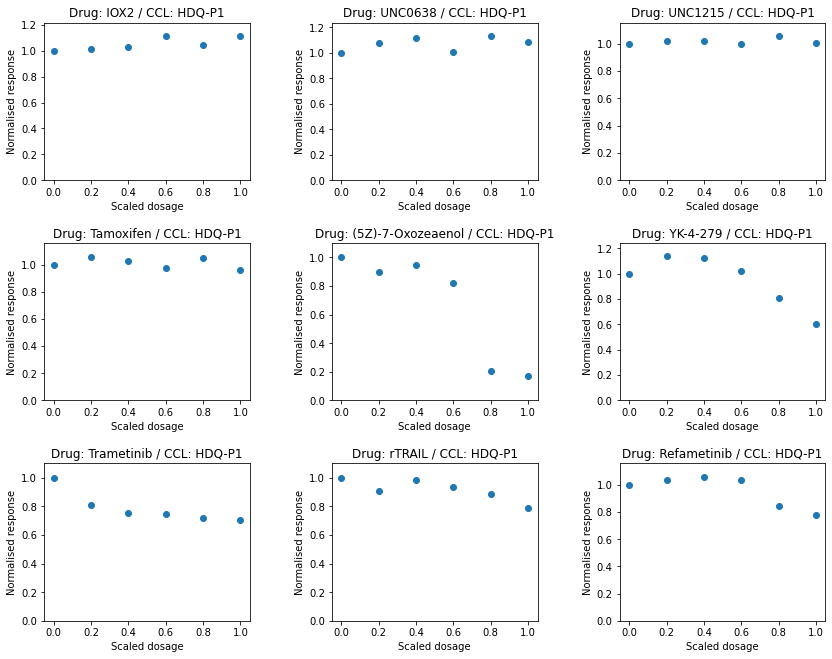

In [31]:
df = drug_curves[drug_curves["count_missing"]!=0]
print("Number of samples with missing data", df.shape[0])

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names)

## Hypothesis: for all the records with missing data there is a "dublicate" with the whole range

In [32]:
drug_curves["count_missing"] = drug_curves[response_norm].isnull().sum(axis=1)
conc_gr = drug_curves.groupby(["drug_name", "CCL_name"]).agg(n_conc = ("MAX_CONC", "nunique"),
                                                            n_samples = ("MAX_CONC", "count"),
                                                            sum_missing = ("count_missing", "sum"))


conc_gr.groupby(["sum_missing", "n_samples"]).agg(count = ("n_conc", "count"))

count
sum_missing n_samples        
0           1          177202
            2            2661
4           1           24620
            2            9120

### Conclusion: Among 33740 profiles with missing points, only 9120 have dublicates/alternatives

## Some of the profiles with missing data are not so bad

Number of not bad data: 1389


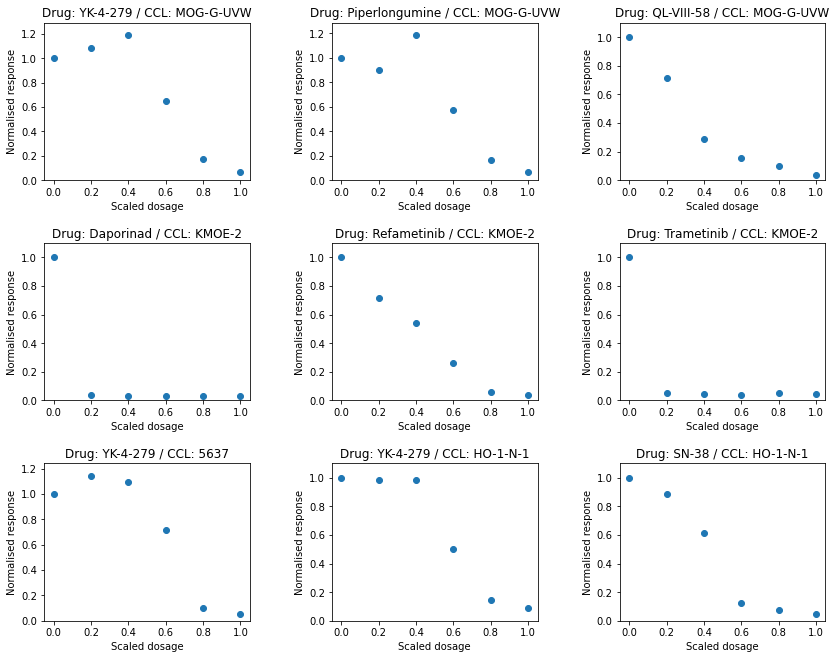

In [33]:
df = drug_curves[(drug_curves["count_missing"]!=0 )
                 & (drug_curves["norm_cells_4"]<0.2)
                 & (drug_curves["norm_cells_5"]<0.2)
                ]
                 
print("Number of not bad data:", df.shape[0])

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[60:69],
                  drug_dict = drug_names, CCL_dict = CCL_names)

## Ambigous data: Are some points wrong?

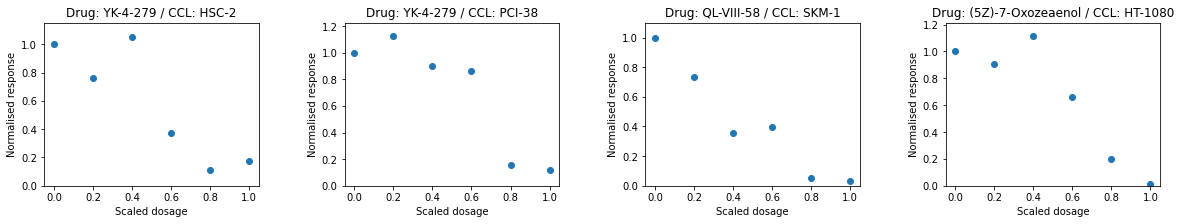

In [34]:
specific_samples = [("YK-4-279", "HSC-2"),
                    ("YK-4-279", "PCI-38"),
                   ("QL-VIII-58", "SKM-1"),
                    ("(5Z)-7-Oxozeaenol", "HT-1080")
                   ]
show_specific(drug_curves, specific_samples, conc_columns, response_norm)

# Part 3: Explore  curves with normalised responses above 1.0

In [35]:
%%time
# Number of responses > 1
drug_curves["high_responses"] = drug_curves[response_norm].apply(lambda row: sum(row>1), axis=1)
drug_curves[["high_responses"]+ response_norm]

CPU times: user 44.3 s, sys: 385 ms, total: 44.6 s
Wall time: 46.1 s


,high_responses,norm_cells_0,norm_cells_1,norm_cells_2,norm_cells_3,norm_cells_4,norm_cells_5,norm_cells_6,norm_cells_7,norm_cells_8,norm_cells_9
0,7,1,1.039343,0.998020,1.005715,1.055723,1.050223,1.035580,1.063019,0.925303,1.083254
1,6,1,0.969418,0.987582,1.052708,1.072808,1.048205,1.009425,1.026961,1.036639,0.752796
2,1,1,0.956127,0.887779,0.941691,0.839059,0.890866,1.206129,0.605122,0.219697,0.072674
3,4,1,1.087946,0.980767,1.118407,1.234735,1.162228,0.948777,0.888637,0.835206,0.720549
4,6,1,1.035268,1.040170,0.972972,1.029729,0.981819,1.045795,1.310285,1.222109,0.998711
...,...,...,...,...,...,...,...,...,...,...,...
225379,3,1,0.970321,0.864856,1.326808,1.100719,1.116878,NaN,NaN,NaN,NaN
225380,3,1,0.329169,0.284518,1.088894,1.090624,1.104720,NaN,NaN,NaN,NaN
225381,3,1,0.914628,0.840454,1.116674,1.096159,1.107695,NaN,NaN,NaN,NaN
225382,2,1,0.884687,1.000038,1.051918,0.790004,0.138294,NaN,NaN,NaN,NaN


In [36]:
bad_data = drug_curves[drug_curves["high_responses"]>1]
print("Original data:", drug_curves.shape)
print("Ambiguos data:", bad_data.shape)

Original data: (225384, 30)
Ambiguos data: (127590, 30)


### Note: Half of the data can be regarded as ambiguous!!!

In [37]:
bad_data["high_responses"].value_counts()

2    28485
3    24334
4    20015
5    17201
6    12366
7    10712
8     8487
9     5990
Name: high_responses, dtype: int64

## Bad data by drug

In [38]:
%%time
dr1 = drug_curves.groupby(["DRUG_ID"], as_index=False).agg(curves_count_all = ("COSMIC_ID", "count"))

dr2 = bad_data.groupby(["DRUG_ID"], as_index=False).agg(curves_count_bad = ("COSMIC_ID", "count"),
                                                       min_bad_responses = ("high_responses", "min"),
                                                        max_bad_response = ("high_responses", "max"),
                                                        avg_bad_responses = ("high_responses", "mean"),
                                                       )

dr2["avg_bad_responses"] = round(dr2["avg_bad_responses"], 2)

dr = pd.merge(right = dr1, left =dr2, on="DRUG_ID", how="left")
dr["drug_name"] = dr["DRUG_ID"].map(drug_names)
dr["percent_bad"] = round(dr["curves_count_bad"]/dr["curves_count_all"], 3)

show_columns = ['DRUG_ID', 'drug_name', 'percent_bad', 'curves_count_all','curves_count_bad', 
                'min_bad_responses', 'max_bad_response','avg_bad_responses']
dr = dr[show_columns].copy()

CPU times: user 63.5 ms, sys: 9.51 ms, total: 73 ms
Wall time: 88.2 ms


In [39]:
dr.sort_values("percent_bad", ascending = False, inplace=True)
dr.head(10)

,DRUG_ID,drug_name,percent_bad,curves_count_all,curves_count_bad,min_bad_responses,max_bad_response,avg_bad_responses
190,1025,SB216763,0.954,786,750,2,9,5.98
197,1033,Vismodegib,0.950,893,848,2,9,5.93
47,150,Bicalutamide,0.947,932,883,2,9,6.00
161,332,XMD15-27,0.947,980,928,2,9,6.50
183,1018,Veliparib,0.919,894,822,2,9,5.79
178,1013,Nilotinib,0.915,844,772,2,9,5.69
182,1017,Olaparib,0.908,894,812,2,9,5.53
185,1020,Lenalidomide,0.908,894,812,2,9,5.58
232,1170,CCT-018159,0.901,945,851,2,9,4.93
163,341,Selisistat,0.899,975,877,2,9,5.77


## Bad data by CCL

In [40]:
%%time
cl1 = drug_curves.groupby(["COSMIC_ID"], as_index=False).agg(curves_count_all = ("DRUG_ID", "count"))

cl2 = bad_data.groupby(["COSMIC_ID"], as_index=False).agg(curves_count_bad = ("DRUG_ID", "count"),
                                                       min_bad_responses = ("high_responses", "min"),
                                                        max_bad_response = ("high_responses", "max"),
                                                        avg_bad_responses = ("high_responses", "mean"),
                                                       )

cl2["avg_bad_responses"] = round(cl2["avg_bad_responses"], 2)

cl = pd.merge(right = cl1, left =cl2, on="COSMIC_ID", how="left")
cl["CCL_name"] = cl["COSMIC_ID"].map(CCL_names)
cl["percent_bad"] = round(cl["curves_count_bad"]/cl["curves_count_all"], 3)

show_columns = ['COSMIC_ID', 'CCL_name', 'percent_bad', 'curves_count_all','curves_count_bad', 
                'min_bad_responses', 'max_bad_response','avg_bad_responses']
cl = cl[show_columns].copy()

CPU times: user 54.8 ms, sys: 8.12 ms, total: 62.9 ms
Wall time: 67.3 ms


In [41]:
cl.sort_values("percent_bad", ascending = False, inplace=True)
cl.head(10)

,COSMIC_ID,CCL_name,percent_bad,curves_count_all,curves_count_bad,min_bad_responses,max_bad_response,avg_bad_responses
62,688022,NCI-H378,1.000,2,2,5,5,5.00
670,924241,NCI-H250,1.000,1,1,5,5,5.00
985,1330969,NCI-H1404,0.837,43,36,2,9,5.44
75,713880,SBC-5,0.816,217,177,2,9,5.45
564,909907,ZR-75-30,0.813,91,74,2,9,5.66
503,909711,SCH,0.806,252,203,2,9,5.67
894,1298162,K8,0.802,126,101,2,9,5.26
402,907799,MC116,0.802,258,207,2,9,4.79
714,949092,CP67-MEL,0.800,25,20,2,6,3.25
378,907312,KU-19-19,0.793,222,176,2,9,5.03


## Check whether bad data are actually bad

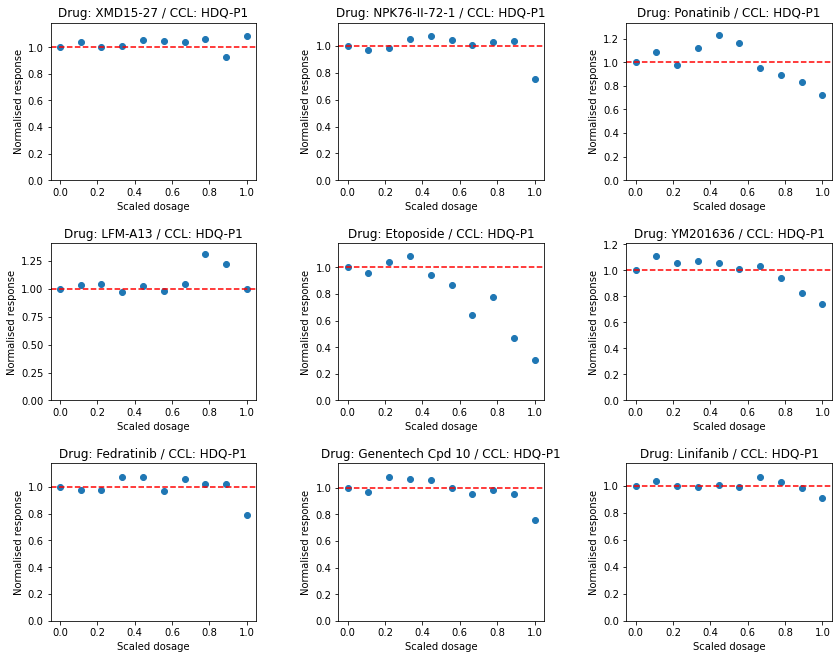

In [42]:
df = bad_data
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 2 bad responses

Number of samples with 2 bad responses: 28485


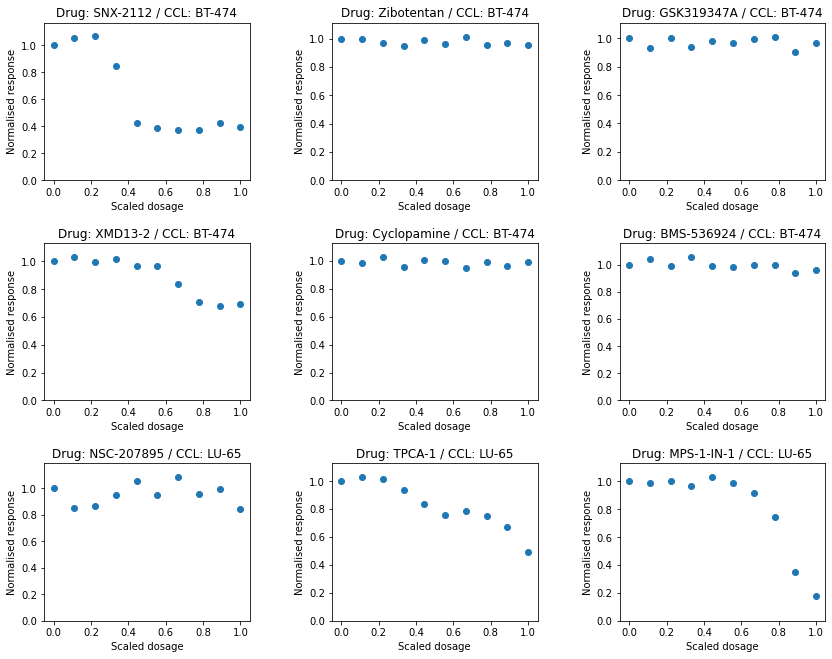

In [43]:
N = 2
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

### Among samples with only 2 norm_responses >1 some data are not so bad

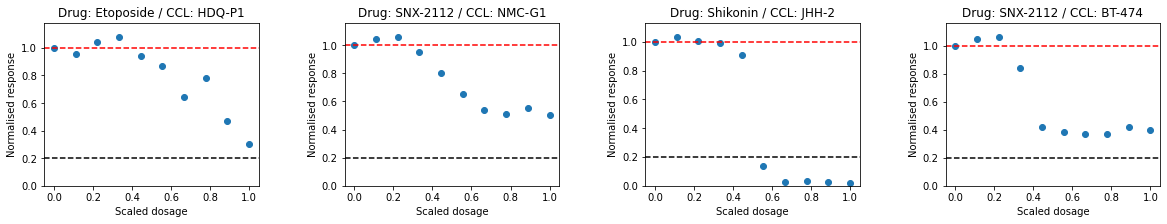

In [44]:
specific_samples = [("Etoposide", "HDQ-P1"),
                    ("SNX-2112", "NMC-G1"),
                    ("Shikonin", "JHH-2"),
                    ("SNX-2112", "BT-474")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 2 bad responses, but with 2 last responses below 0.2: 2728


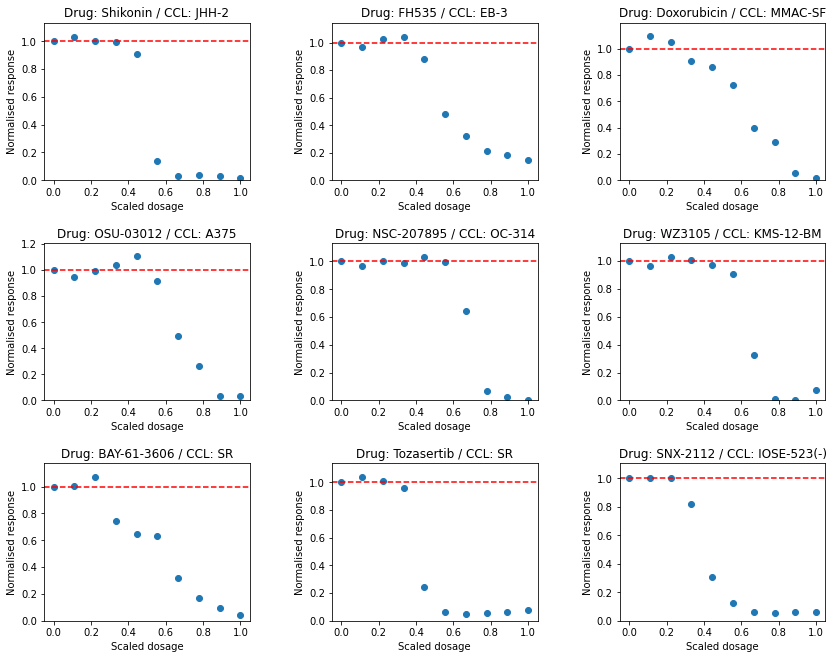

In [45]:
N = 2
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

### Conclusion - we can't delete just samples which with 2 responses>1.0
### The question: What is the accuracy of measuring responses? <br>Can we treat samples with responses up to 1.01 as valid ones?

## Samples with 3 bad responses

Number of samples with 3 bad responses: 24334


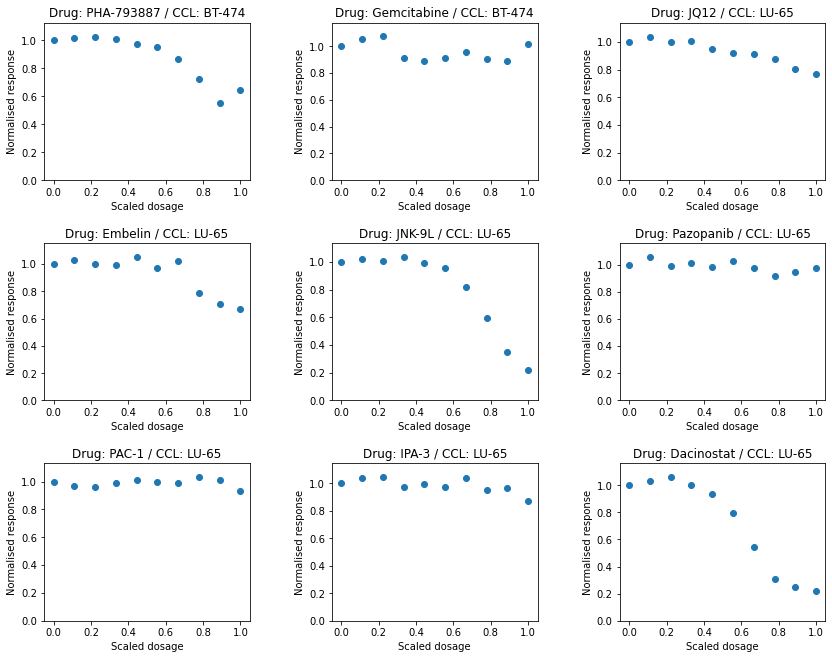

In [46]:
N = 3
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[30:39],
                  drug_dict = drug_names, CCL_dict = CCL_names)

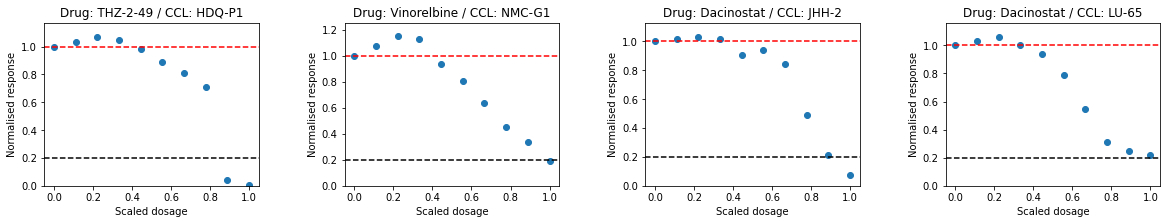

In [47]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Vinorelbine", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("Dacinostat", "LU-65")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 3 bad responses, but with 2 last responses below 0.2: 1780


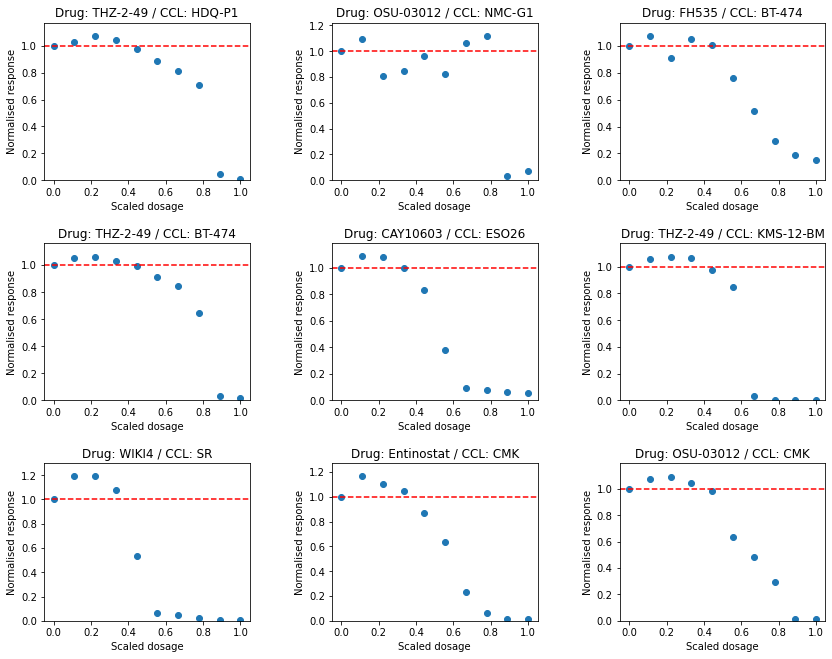

In [48]:
N = 3
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 4 bad responses 

Number of samples with 4 bad responses: 20015


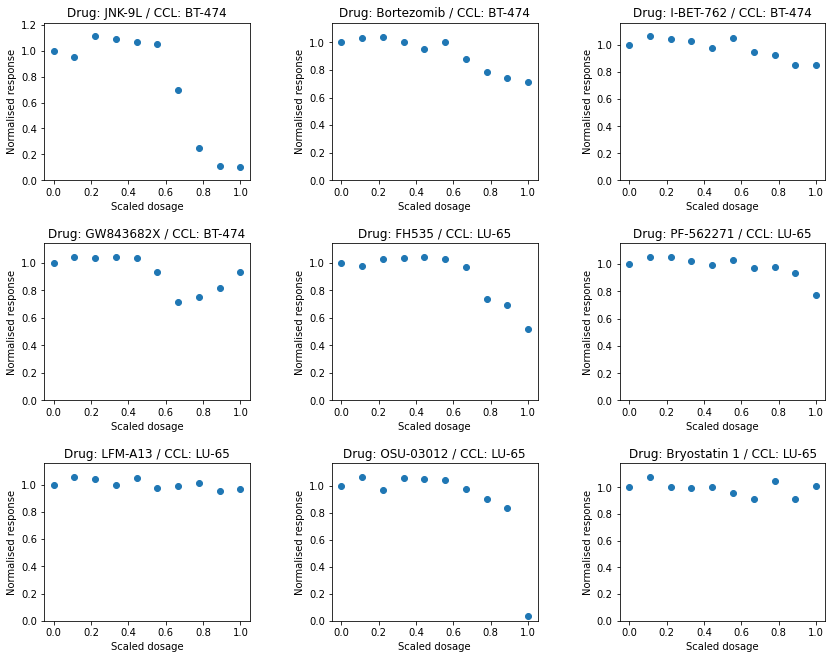

In [49]:
N = 4
df = bad_data[bad_data["high_responses"]==N]
print("Number of samples with %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

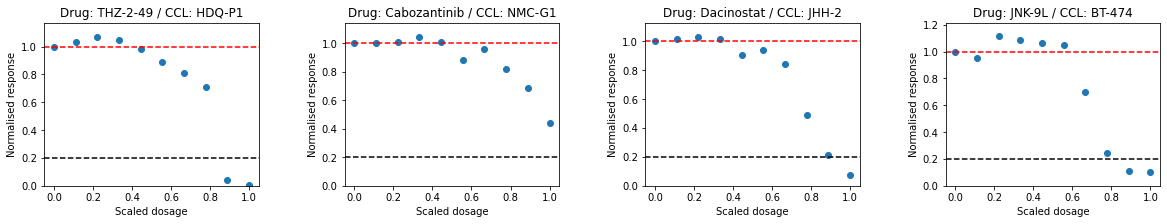

In [50]:
specific_samples = [("THZ-2-49", "HDQ-P1"),
                    ("Cabozantinib", "NMC-G1"),
                    ("Dacinostat", "JHH-2"),
                    ("JNK-9L", "BT-474")
                   ]
show_specific(bad_data, specific_samples, conc_columns, response_norm, upper_limit=1, lower_limit=0.2)

Number of samples with 4 bad responses, but with 2 last responses below 0.2: 879


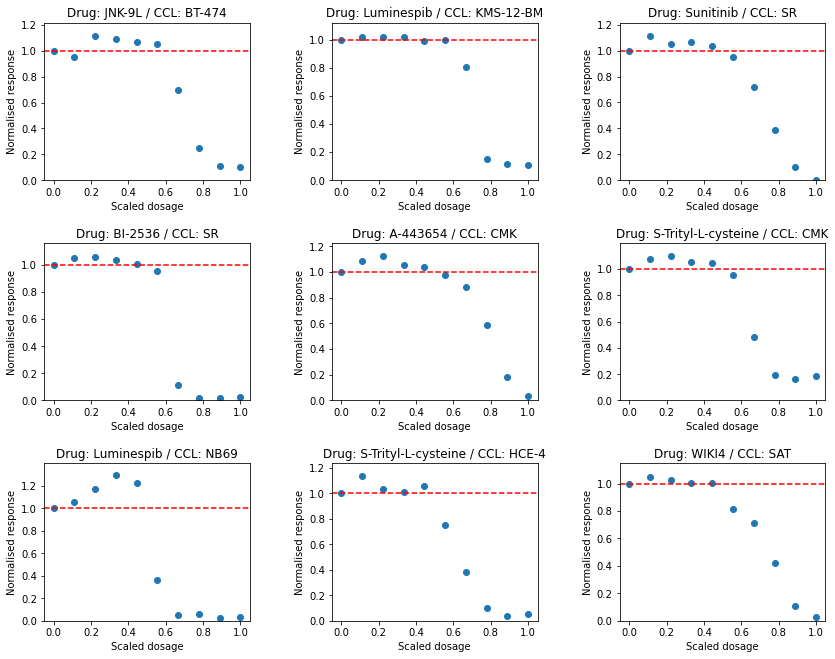

In [51]:
N = 4
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Samples with 5+ bad responses

Number of samples with more than 5 bad responses: 54756


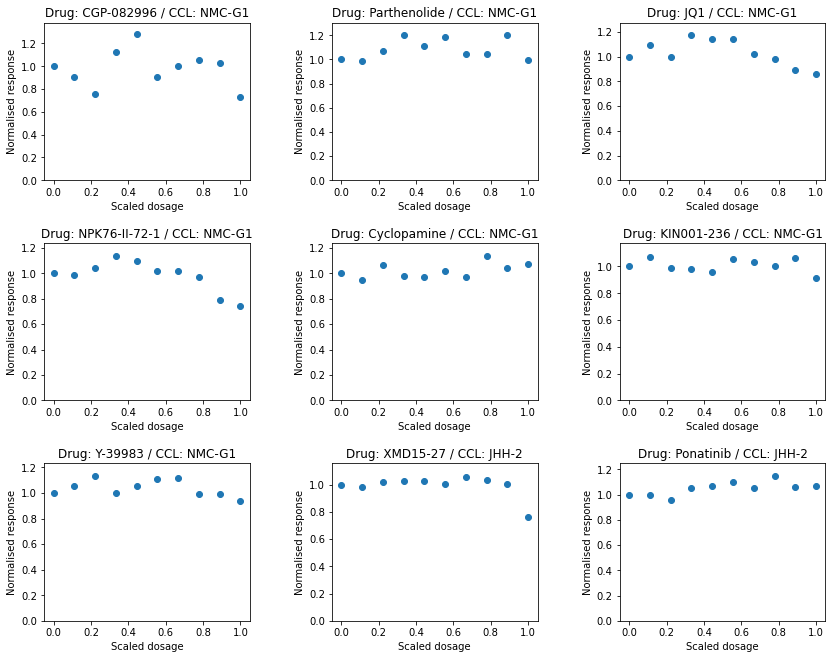

In [52]:
N = 5
df = bad_data[bad_data["high_responses"]>=N]
print("Number of samples with more than %d bad responses: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[20:29],
                  drug_dict = drug_names, CCL_dict = CCL_names)

Number of samples with 5 bad responses, but with 2 last responses below 0.2: 441


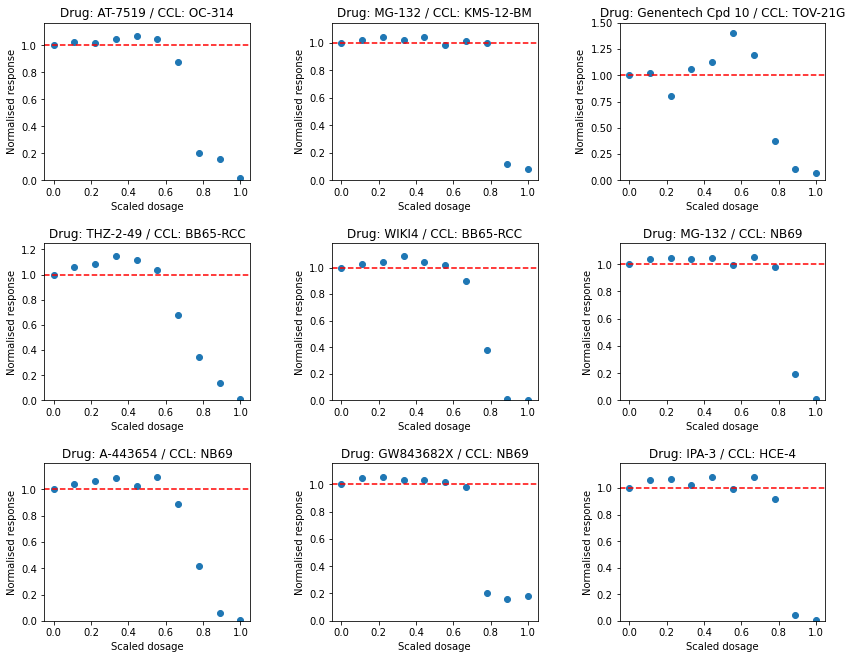

In [53]:
N = 5
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 6 bad responses, but with 2 last responses below 0.2: 135


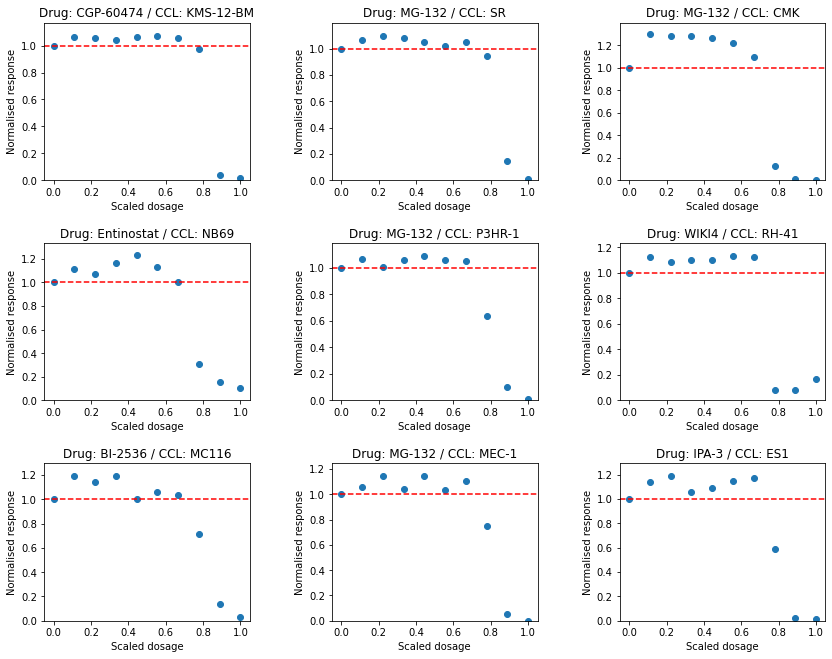

In [54]:
N = 6
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 7 bad responses, but with 2 last responses below 0.2: 18


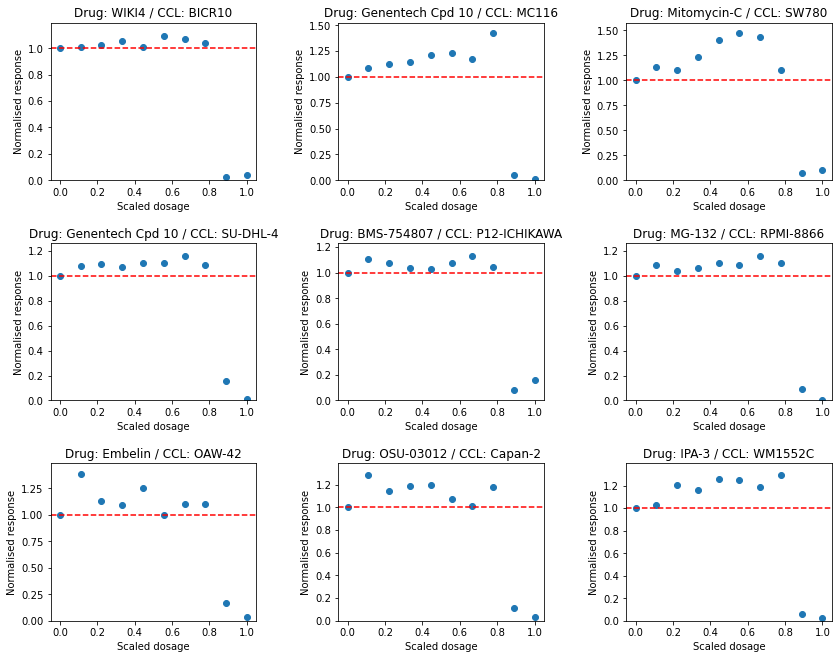

In [55]:
N = 7
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

In [56]:
N = 8
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 8 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1008x792 with 0 Axes>

In [57]:
N = 9
df = bad_data[(bad_data["high_responses"]==N) & (bad_data["norm_cells_9"]<0.2) & (bad_data["norm_cells_8"]<0.2)]
print("Number of samples with %d bad responses, but with 2 last responses below 0.2: %d" % (N, df.shape[0]))

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

Number of samples with 9 bad responses, but with 2 last responses below 0.2: 0


<Figure size 1008x792 with 0 Axes>

### Conclusion from Part 3: Curves with up to 7 suspiciously high normalised responses look pretty reasonable

## Part 4: Explore curves with normalised response above 1 but low final response

In [58]:
%%time
drug_curves["low_response_02"] = (drug_curves[response_norm]<=0.2).sum(axis=1)
drug_curves["low_response_04"] = (drug_curves[response_norm]<=0.4).sum(axis=1)

CPU times: user 44 ms, sys: 21.2 ms, total: 65.2 ms
Wall time: 62.7 ms


In [59]:
not_bad_02 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_02"])]
not_bad_04 = drug_curves[(drug_curves["high_responses"]>1) & (drug_curves["low_response_04"])]
print("Number of all suspicious samples:", bad_data.shape[0])
print("\nNumber of potentionally good samples among all bad data:")
print("With responses below 0.2:", not_bad_02.shape[0])
print("With responses below 0.4:", not_bad_04.shape[0])

Number of all suspicious samples: 127590

Number of potentionally good samples among all bad data:
With responses below 0.2: 9892
With responses below 0.4: 16438


In [60]:
not_bad_02["low_response_02"].value_counts()

1    7742
3    1755
5     387
7       8
Name: low_response_02, dtype: int64

In [61]:
not_bad_04["low_response_04"].value_counts()

1    12144
3     3301
5      974
7       19
Name: low_response_04, dtype: int64

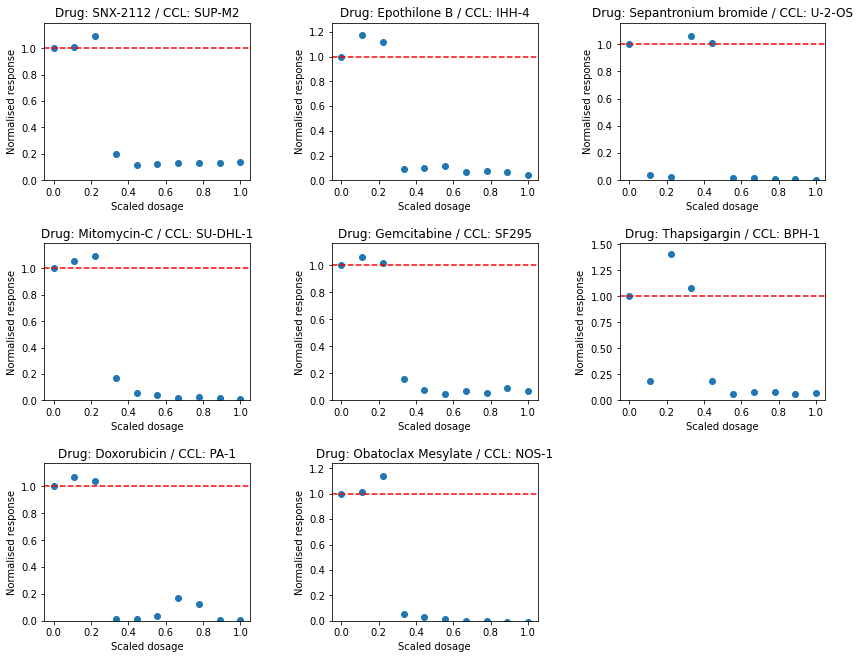

In [62]:
df = not_bad_02[not_bad_02["low_response_02"]==7]

show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

# Part 5: Repeat with an additional constrain 
## Among all "middle" datapoints a subsequent point should not be higher than antecedent by some limit

In [63]:
not_bad_02_2 = cut_off_outliers(drug_curves, middle_points_limit=-0.2, response_columns = response_norm)

print("Before filtration: %d, After filtration: %d" % (not_bad_04.shape[0], not_bad_02_2.shape[0]))
not_bad_02_2["low_response_02"].value_counts()

Before filtration: 16438, After filtration: 190245


0    151335
1     16124
2      7155
3      5384
4      4025
5      2654
6      1551
7       857
9       678
8       482
Name: low_response_02, dtype: int64

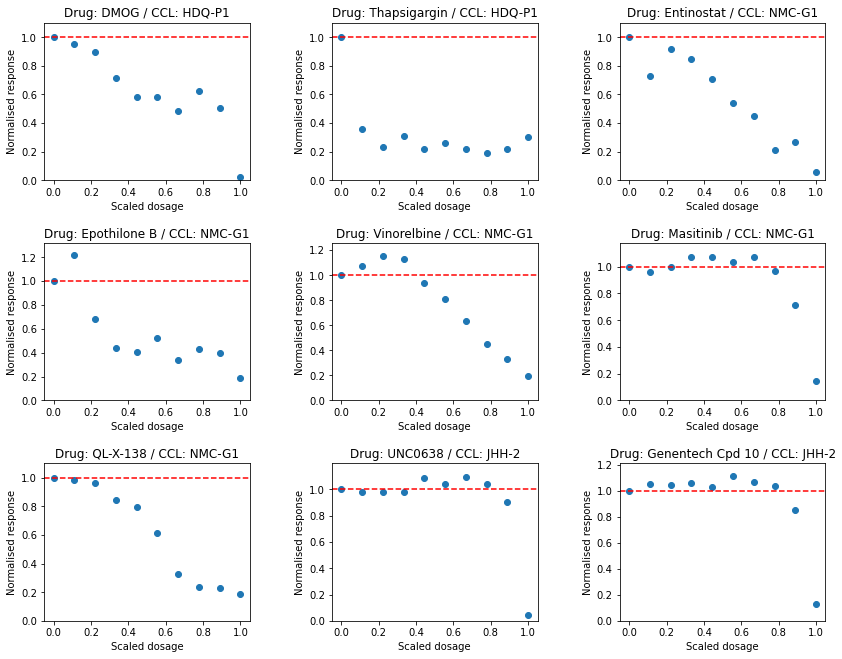

In [64]:
df = not_bad_02_2[not_bad_02_2["low_response_02"]==1]
show_response_curves(df, plots_in_row=3, plots_in_column=3, \
                   x_columns=conc_columns, y_columns=response_norm, indexes=df.index[:9],
                  drug_dict = drug_names, CCL_dict = CCL_names, upper_limit=1)

## Further ideas